In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data cropping and inputation

In [13]:
df = pd.read_pickle('../data/data_discretised.pkl') 

In [14]:
# Create the datetime column without considering 30min_interval
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Add the 30min_interval as a Timedelta
df['date'] += pd.to_timedelta(df['30min_interval'] * 30, unit='m')

In [15]:
df

,user,year,month,day,hour,30min_interval,timestamp,stoplocation,latitude,longitude,lat_bin,lon_bin,date
0,0.0,2013,10,31,12,1.0,2013-10-31 12:16:30,98,55.783644,12.518416,143,142,2013-10-31 12:30:00
1,0.0,2013,10,31,12,2.0,2013-10-31 12:30:44,28,55.781990,12.521609,142,143,2013-10-31 13:00:00
2,0.0,2013,10,31,13,1.0,2013-10-31 13:01:29,28,55.781990,12.521609,142,143,2013-10-31 13:30:00
3,0.0,2013,10,31,13,2.0,2013-10-31 13:30:59,28,55.781990,12.521609,142,143,2013-10-31 14:00:00
4,0.0,2013,10,31,14,1.0,2013-10-31 14:00:52,28,55.781990,12.521609,142,143,2013-10-31 14:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12827787,851.0,2015,8,7,20,1.0,2015-08-07 20:03:13,26,56.123877,9.849060,200,0,2015-08-07 20:30:00
12827788,851.0,2015,8,7,20,2.0,2015-08-07 20:33:14,26,56.123877,9.849060,200,0,2015-08-07 21:00:00
12827789,851.0,2015,8,7,21,1.0,2015-08-07 21:03:15,26,56.123877,9.849060,200,0,2015-08-07 21:30:00
12827790,851.0,2015,8,7,21,2.0,2015-08-07 21:33:15,26,56.123877,9.849060,200,0,2015-08-07 22:00:00


In [16]:
# remove all rows with date < 2014-01-05 and date > 2014-06-25
# df = df[(df['date'] >= '2014-01-05') & (df['date'] <= '2014-06-25')]

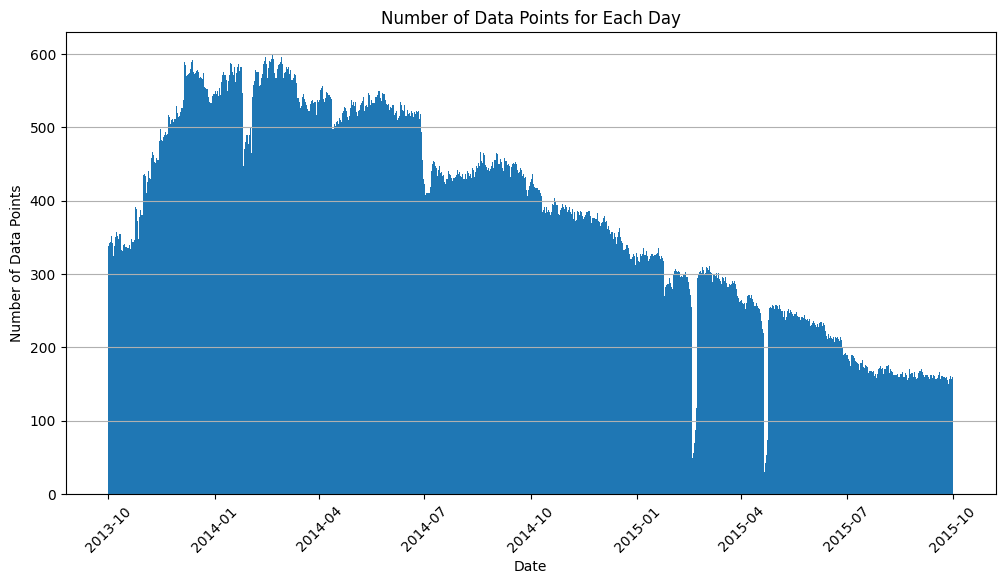

In [48]:
# Group the data by the 'date' column and count the number of data points for each date
date_count = df.groupby('date').size().reset_index(name='count')

# Sort by date for better visualization
date_count = date_count.sort_values('date')

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(date_count['date'], date_count['count'])
plt.xlabel('Date')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points for Each Day')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Add horizontal grid lines

plt.show()

We add new column to the data frame called "label" wich has 4 possible labels: "stop", "moving", "outside", or "missing". A row gets the label "stop" if it has a positive integer in the column "stoplocation", "moving" if the column "stoplocation" equals -1, "outside" if one of lan_bin, or lat_bon equals 200

In [18]:
def label_row(row):
    stoplocation = str(row['stoplocation'])  # Convert stoplocation to string to work with its digits
    lat_bin = row['lat_bin']
    lon_bin = row['lon_bin']

    # Check last two digits of 'stoplocation'
    last_two_digits = stoplocation[-2:]
    last_digit = stoplocation[-1:]

    # Label as 'stop'
    if last_two_digits.isnumeric() and int(last_two_digits) > -1:
        return 'stop'
    elif last_digit.isnumeric() and int(last_digit) > 0:
        return 'stop' 
    elif last_two_digits == '_1':
        return 'stop'
    # Label as 'moving'
    elif last_two_digits == '-1':
        return 'moving'
    # Label as 'outside'
    elif lat_bin == 200 or lat_bin == 0 or lon_bin == 200 or lon_bin == 0:
        return 'outside'
    # Label as 'missing'
    else:
        return 'missing'

# Apply the custom function to each row to create the 'label' column
df['label'] = df.apply(label_row, axis=1)


In [19]:
# Adding a new column 'label' based on the conditions
df['label'] = df.apply(lambda row: 
                        'outside' if row['lat_bin'] == 200 or row['lat_bin'] == 0 or row['lon_bin'] == 200 or row['lon_bin'] == 0 else
                        ('stop' if str(row['stoplocation']).split('_')[-1] != '-1' else 
                         ('moving' if str(row['stoplocation']).split('_')[-1] == '-1' else 
                          'missing')),
                        axis=1)

<Axes: xlabel='label'>

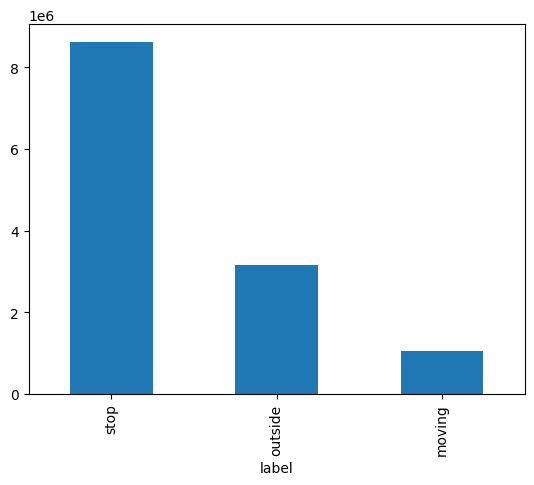

In [20]:
# show the distribution of the labels as bar chart
df['label'].value_counts().plot(kind='bar')

The dataframe does not contain missing data. We will add the rows with missing data and label them as "missing".

In [21]:
from itertools import product

# Unique values for creating all combinations
unique_users = df['user'].unique()
unique_years = df['year'].unique()
unique_months = df['month'].unique()
unique_days = df['day'].unique()
unique_hours = df['hour'].unique()
unique_intervals = df['30min_interval'].unique()

# Generate all combinations of user, year, month, day, hour, and 30-minute interval
all_combinations = pd.DataFrame(list(product(unique_users, unique_years, unique_months, unique_days, unique_hours, unique_intervals)), 
                                columns=['user', 'year', 'month', 'day', 'hour', '30min_interval'])

# Merge this DataFrame with the original DataFrame
merged_df = pd.merge(all_combinations, df, on=['user', 'year', 'month', 'day', 'hour', '30min_interval'], how='left')

# Fill NaN values and add the "missing" label where necessary
merged_df['label'] = merged_df.apply(lambda row: 'missing' if pd.isnull(row['stoplocation']) else row['label'], axis=1)
merged_df[['stoplocation', 'latitude', 'longitude', 'lat_bin', 'lon_bin']].fillna(np.nan, inplace=True)

# Sort the DataFrame for better readability (optional)
merged_df.sort_values(by=['user', 'year', 'month', 'day', 'hour', '30min_interval'], inplace=True)


/tmp/ipykernel_985761/1318317719.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[['stoplocation', 'latitude', 'longitude', 'lat_bin', 'lon_bin']].fillna(np.nan, inplace=True)


Remove wrong day month combinations

In [22]:
def is_valid_date(row):
    try:
        pd.Timestamp(year=row['year'], month=row['month'], day=row['day'])
        return True
    except ValueError:
        return False

# Use the 'is_valid_date' function to filter the DataFrame
mask = merged_df.apply(is_valid_date, axis=1)
merged_df = merged_df[mask]

In [23]:
# Create the datetime column without considering 30min_interval
merged_df['datetime'] = pd.to_datetime(merged_df[['year', 'month', 'day', 'hour']])

# Add the 30min_interval as a Timedelta
merged_df['datetime'] += pd.to_timedelta(merged_df['30min_interval'] * 30, unit='m')

/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


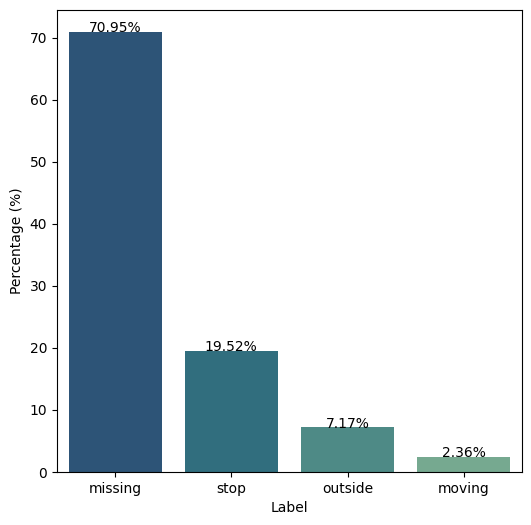

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the frequencies of each label
label_counts = merged_df['label'].value_counts()

# Calculate the percentages of each label
total = len(merged_df)
label_percentage = (label_counts / total) * 100

# Create the bar plot with Viridis color palette
plt.figure(figsize=(6, 6))
sns.barplot(x=label_percentage.index, y=label_percentage.values, palette='crest_r')

# Label the axes
plt.xlabel('Label')
plt.ylabel('Percentage (%)')

# Annotate the bars with the actual percentages
for index, value in enumerate(label_percentage.values):
    plt.text(index, value, f'{value:.2f}%', color='black', ha='center')
    
# save the plot
plt.savefig('../figures/missing_data_distribution.png', dpi = 300, bbox_inches='tight')

# Show the plot
plt.show()


/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

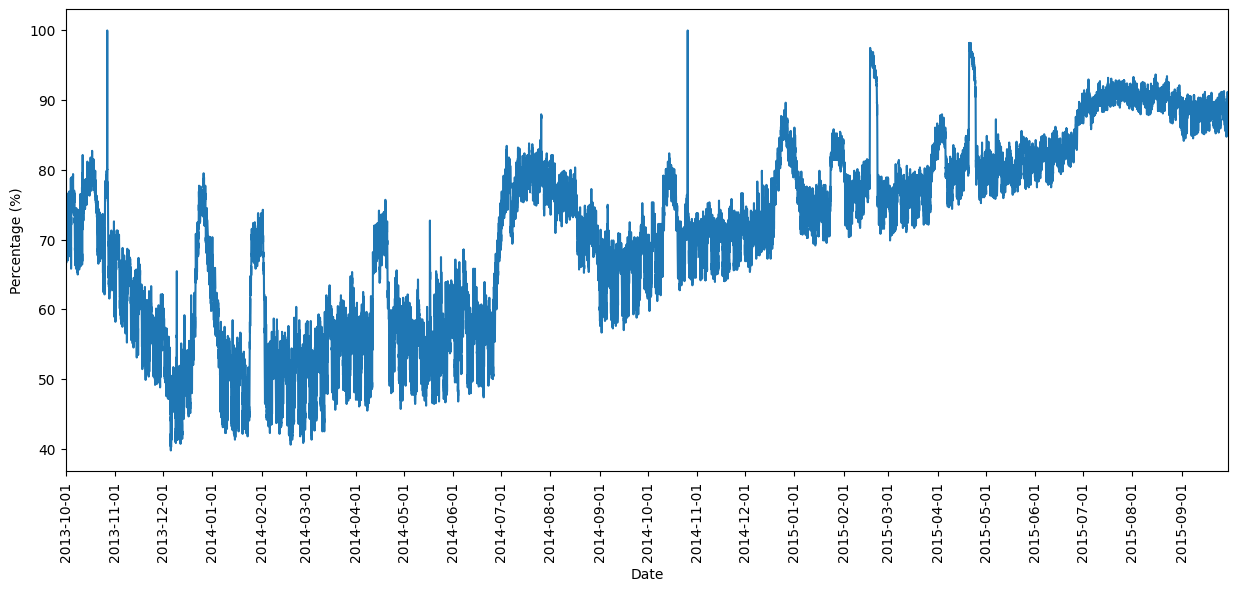

In [36]:
# Step 1: Count the number of 'bad data' and 'total' data points for each day
count_df = merged_df.groupby(['datetime', 'label']).size().reset_index(name='count')
total_count_df = merged_df.groupby(['datetime']).size().reset_index(name='total_count')

# Step 2: Merge the two DataFrames and calculate the percentage
merged_count_df = pd.merge(count_df, total_count_df, on=['datetime'], how='left')
merged_count_df['percentage'] = (merged_count_df['count'] / merged_count_df['total_count']) * 100

# Filter to only include rows with the 'bad data' labels
bad_data_df = merged_count_df[merged_count_df['label'].isin(['missing', 'moving', 'outside'])]

# Group by date and sum percentages of bad data
bad_data_df = bad_data_df.groupby('datetime')['percentage'].sum().reset_index()

# Step 3: Plot the percentage of bad data over time
plt.figure(figsize=(15, 6))
sns.lineplot(x='datetime', y='percentage', data=bad_data_df)
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(pd.date_range(start='2013-10-01', end='2015-09-30', freq='MS'), rotation=90)
plt.xlim(pd.Timestamp('2013-10-01'), pd.Timestamp('2015-09-30'))

# save the plot
plt.savefig('../figures/bad_data_distribution.png', dpi = 300, bbox_inches='tight')

plt.show()

In [16]:
# remove all rows with date between the 22nd of January and the 4th of February
# merged_df = merged_df[(merged_df['date'] < '2014-01-22') | (merged_df['date'] > '2014-02-04')]
# remove also all rows with date between the 10th of April and the 23rd of April
# merged_df = merged_df[(merged_df['date'] < '2014-04-10') | (merged_df['date'] > '2014-04-23')]

In [37]:
import matplotlib.colors as mcolors

# Step 1: Group and count
grouped_df = merged_df.groupby(['user', 'datetime', 'label']).size().reset_index(name='count')

# Step 2: Find the most frequent label for each user and each day
idx = grouped_df.groupby(['user', 'datetime'])['count'].idxmax()
most_frequent_df = grouped_df.loc[idx].pivot(index='user', columns='datetime', values='label')

# Generate color mapping for unique labels
unique_labels = grouped_df['label'].unique()
colors = list(mcolors.TABLEAU_COLORS.keys())
color_map = dict(zip(unique_labels, colors[:len(unique_labels)]))

# Step 3: Plot the matrix
plt.figure(figsize=(80, 80))

for i, (user, row) in enumerate(most_frequent_df.iterrows()):
    for j, (date, label) in enumerate(row.items()):
        if not pd.isna(label):
            plt.fill_betweenx([i, i + 1], j, j + 1, color=color_map[label])

plt.yticks(np.arange(len(most_frequent_df.index)) + 0.5, most_frequent_df.index)
plt.xticks(np.arange(len(most_frequent_df.columns)), most_frequent_df.columns, rotation=90)

plt.ylabel('User Number')
plt.xlabel('Date')
plt.title('Most Frequent Labels for Each User and Date')

# Add legend
handles = [plt.Rectangle((0,0), 1, 1, color=color_map[label]) for label in unique_labels]
plt.legend(handles, unique_labels, title='Labels')

# save the plot to png with 300 dpi
plt.savefig('most_frequent_labels.png', dpi=300)

plt.show()



KeyboardInterrupt: 

<Axes: ylabel='Frequency'>

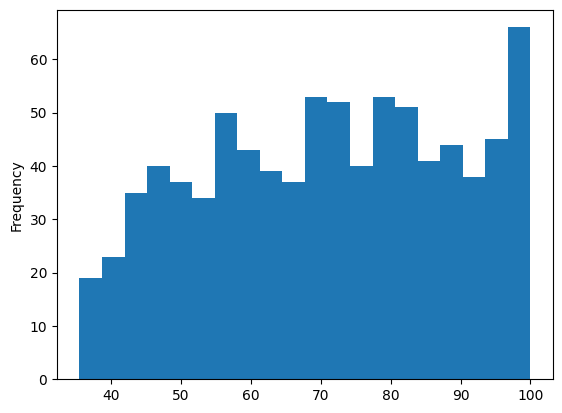

In [ ]:
# Step 1: Calculate the total number of time points for each user
total_count_per_user = merged_df.groupby('user').size().reset_index(name='total_count')

# Step 2: Calculate the number of missing time points for each user
missing_count_per_user = merged_df[merged_df['label'] == 'missing'].groupby('user').size().reset_index(name='missing_count')

# Step 3: Merge the two counts and calculate the percentage
merged_counts = pd.merge(total_count_per_user, missing_count_per_user, on='user', how='left').fillna(0)
merged_counts['missing_percentage'] = (merged_counts['missing_count'] / merged_counts['total_count']) * 100

merged_counts['missing_percentage'].plot(kind='hist', bins=20)

Remove weeks that have more than 24 hours of consecutive "bad data" (outside, missing, or moving)

In [ ]:

merged_df['week_of_year'] = merged_df['datetime'].dt.isocalendar()['week']


# Step 2: Filter the DataFrame for "bad data"
bad_data_df = merged_df[merged_df['label'].isin(['missing', 'moving', 'outside'])]

# Initialize an empty list to hold the results
consecutive_bad_data = []

# Step 3: Loop through each user and week to find the maximum number of consecutive "bad data" 30-minute intervals
for user, user_group in merged_df.groupby('user'):
    for week, week_group in user_group.groupby('week_of_year'):
        week_group = week_group.sort_values(['datetime'])
        
        # Initialize variables
        max_consecutive = 0
        current_consecutive = 0
        
        # Initialize a variable to store the previous datetime object
        prev_datetime = None
        
        for idx, row in week_group.iterrows():
            # Check if the current time is 30 minutes apart from the previous time
            if prev_datetime and row['datetime'] - prev_datetime == pd.Timedelta(minutes=30):
                if row['label'] in ['missing', 'moving', 'outside']:  # Check for bad data
                    current_consecutive += 0.5  # Add 0.5 to the consecutive 30-minute count
                else:  # If good data, reset and update max if necessary
                    max_consecutive = max(max_consecutive, current_consecutive)
                    current_consecutive = 0
            else:
                # Reset and update max if necessary
                max_consecutive = max(max_consecutive, current_consecutive)
                current_consecutive = 0
            
            # Update the previous datetime object
            prev_datetime = row['datetime']
                
        # Update max for the last segment
        max_consecutive = max(max_consecutive, current_consecutive)
        
        consecutive_bad_data.append({'user': user, 'week_of_year': week, 'max_consecutive_bad_data': max_consecutive})
        print(f'User: {user}, Week: {week}, Max Consecutive Bad Data: {max_consecutive}')

# Convert results to DataFrame
result_df = pd.DataFrame(consecutive_bad_data)



User: 0.0, Week: 1, Max Consecutive Bad Data: 143.0
User: 0.0, Week: 2, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 3, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 4, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 5, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 6, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 7, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 8, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 9, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 10, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 11, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 12, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 13, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 14, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 15, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 16, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 17, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 18, Max Consecutive Bad Data: 167.5
User: 0.0, Week: 19, Max Consecutive Bad Data: 167.5
Us

KeyboardInterrupt: 

### plot the distribution of the data

/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


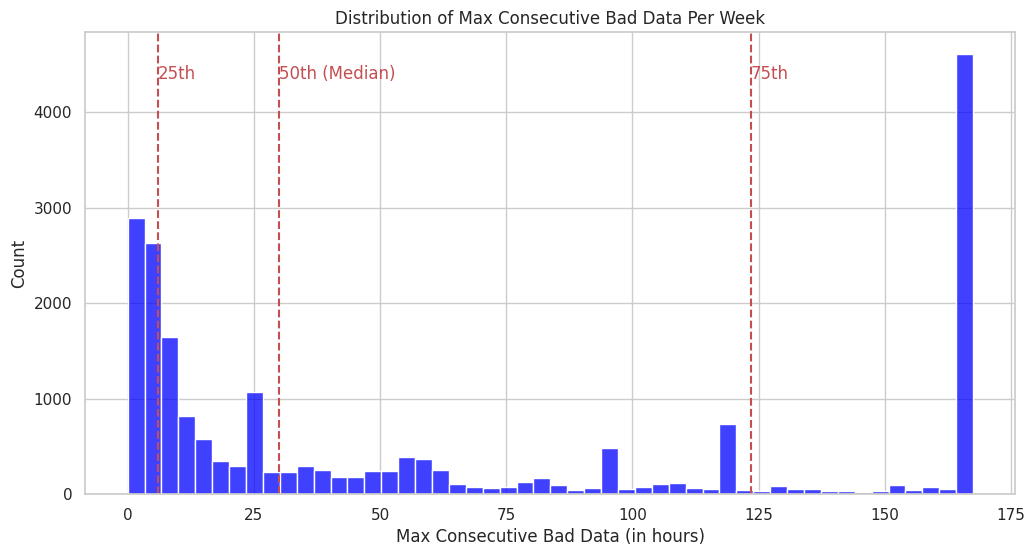

In [ ]:
# Set the style
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(result_df['max_consecutive_bad_data'], bins=50, kde=False, color='blue')

# Calculate percentiles
percentiles = np.percentile(result_df['max_consecutive_bad_data'], [25, 50, 75])

# Add vertical lines for percentiles
for p in percentiles:
    plt.axvline(x=p, color='r', linestyle='--')

# Add percentile labels
plt.text(percentiles[0], plt.ylim()[1] * 0.9, '25th', color='r')
plt.text(percentiles[1], plt.ylim()[1] * 0.9, '50th (Median)', color='r')
plt.text(percentiles[2], plt.ylim()[1] * 0.9, '75th', color='r')

# Add labels and title
plt.xlabel('Max Consecutive Bad Data (in hours)')
plt.ylabel('Count')
plt.title('Distribution of Max Consecutive Bad Data Per Week')

# Show the plot
plt.show()


In [ ]:
# Calculate the 50th percentile (median)
median_value = np.percentile(result_df['max_consecutive_bad_data'], 50)

print(f"The 50th percentile (median) of max consecutive bad data is {median_value} hours.")


The 50th percentile (median) of max consecutive bad data is 30.0 hours.


In [ ]:
# Find weeks with more than 30 hours of consecutively bad data
weeks_to_remove = result_df[result_df['max_consecutive_bad_data'] > 30]

# Initialize an empty DataFrame to hold the filtered data
filtered_df = pd.DataFrame()

# Loop through each user to remove the specific weeks
for user, user_group in merged_df.groupby('user'):
    # Get the weeks to remove for this specific user
    weeks_for_user = weeks_to_remove[weeks_to_remove['user'] == user]['week_of_year'].tolist()
    
    # Remove these weeks from the user's data
    filtered_data = user_group[~user_group['week_of_year'].isin(weeks_for_user)]
    
    # Append the filtered data to the final DataFrame
    filtered_df = pd.concat([filtered_df, filtered_data], ignore_index=True)

### plot missing data again

/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

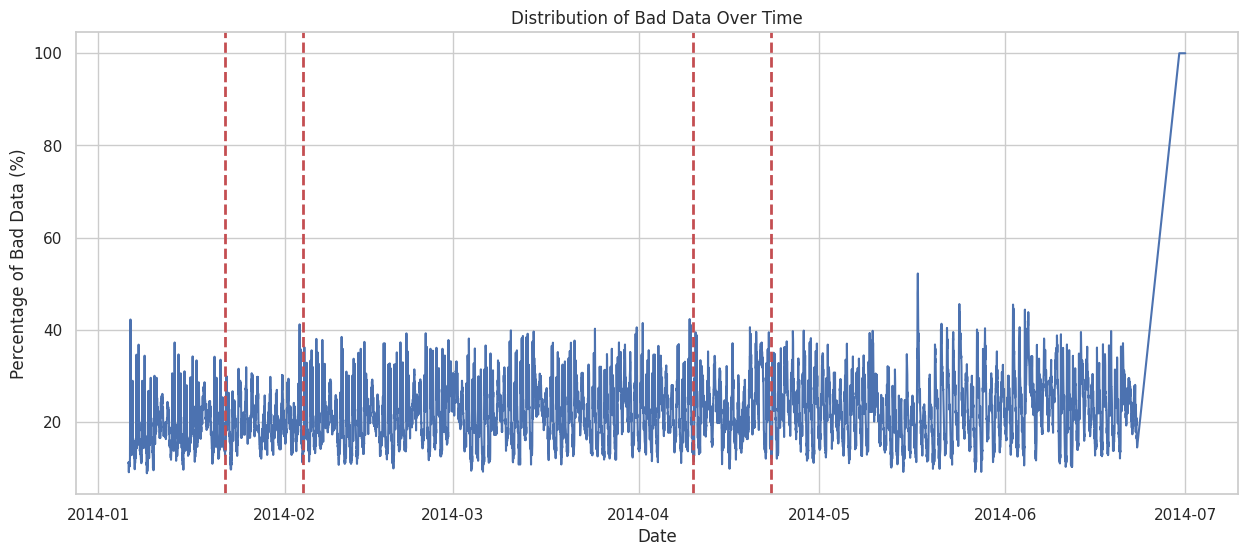

In [ ]:
# Step 1: Count the number of 'bad data' and 'total' data points for each day
count_df = filtered_df.groupby(['datetime', 'label']).size().reset_index(name='count')
total_count_df = filtered_df.groupby(['datetime']).size().reset_index(name='total_count')

# Step 2: Merge the two DataFrames and calculate the percentage
merged_count_df = pd.merge(count_df, total_count_df, on=['datetime'], how='left')
merged_count_df['percentage'] = (merged_count_df['count'] / merged_count_df['total_count']) * 100

# Filter to only include rows with the 'bad data' labels
bad_data_df = merged_count_df[merged_count_df['label'].isin(['missing', 'moving', 'outside'])]

# Group by date and sum percentages of bad data
bad_data_df = bad_data_df.groupby('datetime')['percentage'].sum().reset_index()

# Step 3: Plot the percentage of bad data over time
plt.figure(figsize=(15, 6))
sns.lineplot(x='datetime', y='percentage', data=bad_data_df)
plt.xlabel('Date')
plt.ylabel('Percentage of Bad Data (%)')
plt.axvline(pd.Timestamp('2014-01-22'), color='r', linestyle='--', linewidth=2)
plt.axvline(pd.Timestamp('2014-02-04'), color='r', linestyle='--', linewidth=2)
plt.axvline(pd.Timestamp('2014-04-10'), color='r', linestyle='--', linewidth=2)
plt.axvline(pd.Timestamp('2014-04-23'), color='r', linestyle='--', linewidth=2)
plt.title('Distribution of Bad Data Over Time')
plt.show()

/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


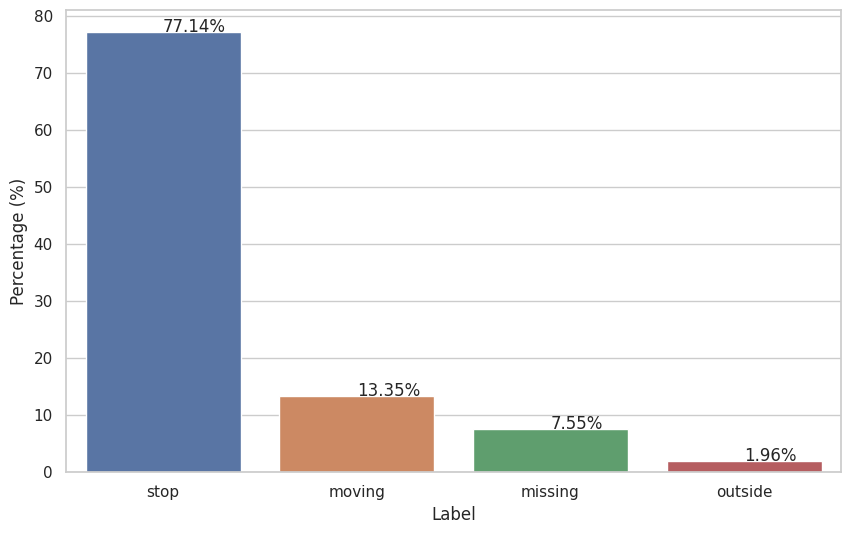

In [ ]:

# Calculate the frequencies of each label
label_counts = filtered_df['label'].value_counts()

# Calculate the percentages of each label
total = len(filtered_df)
label_percentage = (label_counts / total) * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_percentage.index, y=label_percentage.values)

# Label the axes
plt.xlabel('Label')
plt.ylabel('Percentage (%)')

# Annotate the bars with the actual percentages
for index, value in enumerate(label_percentage.values):
    plt.text(index, value, f'{value:.2f}%')

# Show the plot
plt.show()


In [ ]:
# Convert 'user' and 'week_of_year' to string type
filtered_df['user'] = filtered_df['user'].astype(str)
filtered_df['week_of_year'] = filtered_df['week_of_year'].astype(str)

# Zero pad the 'user' and 'week_of_year' so they are of uniform length
filtered_df['user'] = filtered_df['user'].str.zfill(2)  # Padding zeros to have at least two digits
filtered_df['week_of_year'] = filtered_df['week_of_year'].str.zfill(2)  # Padding zeros to have at least two digits

# Create 'user_week' by concatenating 'user' and 'week_of_year'
filtered_df['user_week'] = 'u' + filtered_df['user'] + '_w' + filtered_df['week_of_year']


### add user_week as new index

In [ ]:
def create_user_week(row):
    # Convert the float 'user' value to an integer
    user_int = int(float(row['user']))
    
    # Convert 'week_of_year' to an integer (it's usually already an integer)
    week_int = int(row['week_of_year'])
    
    # Format both as zero-padded two-digit strings
    user_str = f"{user_int:02d}"
    week_str = f"{week_int:02d}"
    
    # Combine them into a single string with '_w' in between
    return f"u{user_str}_w{week_str}"

filtered_df['user_week'] = filtered_df.apply(create_user_week, axis=1)



perform forward filling (ffill) of data within each user_week group for the columns "lat_bin" and "lon_bin" 

In [ ]:
filtered_df.sort_values(by=['user_week', 'year', 'month', 'day', 'hour', '30min_interval'], inplace=True)

In [ ]:
# Define a custom function to forward fill specific columns within each group
def forward_fill_group(group):
    group['lat_bin'] = group['lat_bin'].fillna(method='ffill')
    group['lon_bin'] = group['lon_bin'].fillna(method='ffill')
    group['label'] = np.where(group['lat_bin'].notna() & (group['label'] == 'missing'), 'stop', group['label'])
    return group

# Apply the forward fill operation to specific columns and update the 'label' column
filled_df = filtered_df.groupby('user_week').apply(forward_fill_group)


/tmp/ipykernel_488086/3650722546.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group['lat_bin'] = group['lat_bin'].fillna(method='ffill')
/tmp/ipykernel_488086/3650722546.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group['lon_bin'] = group['lon_bin'].fillna(method='ffill')


plot label distribution

/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


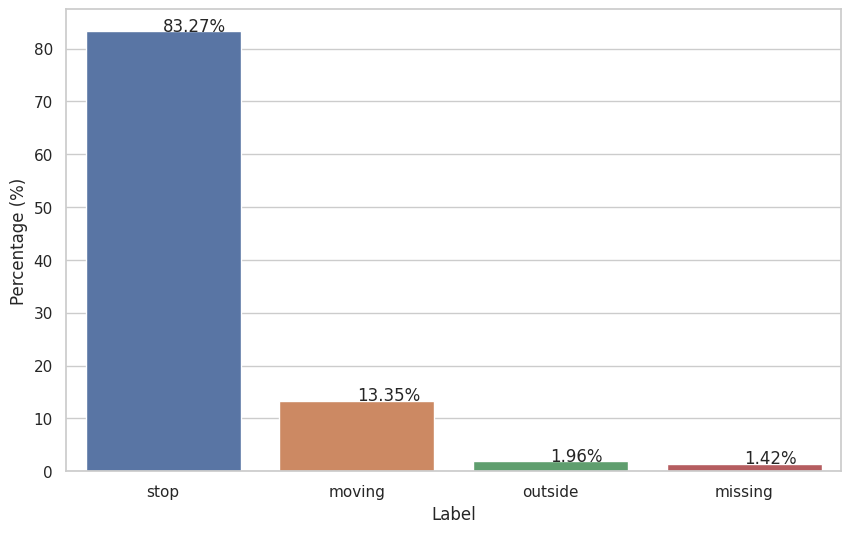

In [ ]:

# Calculate the frequencies of each label
label_counts = filled_df['label'].value_counts()

# Calculate the percentages of each label
total = len(filled_df)
label_percentage = (label_counts / total) * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_percentage.index, y=label_percentage.values)

# Label the axes
plt.xlabel('Label')
plt.ylabel('Percentage (%)')

# Annotate the bars with the actual percentages
for index, value in enumerate(label_percentage.values):
    plt.text(index, value, f'{value:.2f}%')

# Show the plot
plt.show()


<Axes: xlabel='week_of_year'>

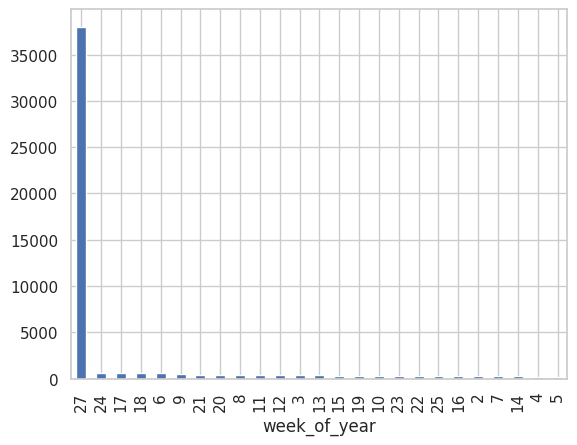

In [ ]:
# show data with label "outside"
filled_df[filled_df['label'] == 'missing'].week_of_year.value_counts().plot(kind='bar')

the 1.42% at missing data can be explained by the fact that the last week seems to have so much missing data that the forward fill did not work anymore. We will remove this week from the data set.  

In [ ]:
# remove week 27
filled_df = filled_df[filled_df['week_of_year'] != 27]

In [ ]:
# remove rows with label "outside" and "moving"
filled_df = filled_df[(filled_df['label'] != 'moving') & (filled_df['label'] != 'outside')]

In [ ]:
# reset indice to user_week
filled_df = filled_df.set_index('user_week')


In [ ]:
# remove columns "user", "year", "month", "day", "hour", "30min_interval", "stoplocation", "latitude", "longitude", "date", "week_of_year", "label"
filled_df = filled_df.drop(columns=["user", "year", "month", "day", "hour", "30min_interval", "stoplocation", "latitude", "longitude", "date", "week_of_year", "label"])

In [ ]:
# reset index
filled_df = filled_df.reset_index()


In [ ]:
filled_df

,user_week,lat_bin,lon_bin,datetime
0,u00_w06,136.0,132.0,2014-02-03 00:00:00
1,u00_w06,136.0,132.0,2014-02-03 00:30:00
2,u00_w06,136.0,132.0,2014-02-03 01:00:00
3,u00_w06,136.0,132.0,2014-02-03 01:30:00
4,u00_w06,136.0,132.0,2014-02-03 02:00:00
...,...,...,...,...
2763194,u99_w25,109.0,122.0,2014-06-22 21:30:00
2763195,u99_w25,109.0,122.0,2014-06-22 22:00:00
2763196,u99_w25,109.0,122.0,2014-06-22 22:30:00
2763197,u99_w25,109.0,122.0,2014-06-22 23:00:00


remove consecutive duplicates

In [ ]:

filled_df['lat_shift'] = filled_df['lat_bin'].shift(1)
filled_df['lon_shift'] = filled_df['lon_bin'].shift(1)
filled_df = filled_df[(filled_df['lat_bin'] != filled_df['lat_shift']) | (filled_df['lon_bin'] != filled_df['lon_shift'])]

# Drop the shift columns
filled_df.drop(['lat_shift', 'lon_shift'], axis=1, inplace=True)


/tmp/ipykernel_488086/1130492848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filled_df.drop(['lat_shift', 'lon_shift'], axis=1, inplace=True)


In [ ]:
# find rows where lat_bin or lon_bin are NaN and remove them
filled_df = filled_df[(filled_df['lat_bin'].notna()) & (filled_df['lon_bin'].notna())]

In [ ]:
# transform lat_bin and lon_bin to int
filled_df['lat_bin'] = filled_df['lat_bin'].astype(int)
filled_df['lon_bin'] = filled_df['lon_bin'].astype(int)

In [ ]:
filled_df

,user_week,lat_bin,lon_bin,datetime
0,u00_w06,136,132,2014-02-03 00:00:00
19,u00_w06,135,132,2014-02-03 09:30:00
20,u00_w06,136,132,2014-02-03 10:00:00
24,u00_w06,135,130,2014-02-03 12:30:00
30,u00_w06,136,132,2014-02-03 16:00:00
...,...,...,...,...
2763112,u99_w25,109,122,2014-06-21 02:30:00
2763129,u99_w25,156,78,2014-06-21 12:00:00
2763142,u99_w25,109,122,2014-06-21 19:00:00
2763164,u99_w25,112,122,2014-06-22 06:00:00


In [ ]:
# combine lat and lon to one column and remove lat and lon
filled_df['pos'] = filled_df[['lat_bin', 'lon_bin']].values.tolist()
filled_df = filled_df.drop(['lat_bin', 'lon_bin'], axis=1)

In [ ]:
# save as csv file
filled_df.to_csv('../data/data_cropped.csv', index=False)

In [ ]:
# save as pickle file
filled_df.to_pickle('../data/data_cropped.pkl')